In [252]:
# basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor as GBR

In [253]:
# Load the dataset
base_dir = "../dataset"
df_data_original = pd.read_csv(f"{base_dir}/dataset.csv")

# make sure there is no NaN value
assert df_data_original.isnull().values.any() == False

In [254]:
# convert (year, month) into (months) since 1948 Jan to create continuous index
base_year = 1948
df_data_original["cum_months"] = df_data_original.apply(
    lambda x: 
        int(12 * (x["year"] - base_year) + x["month"])
    ,
    axis=1
)

In [255]:
df_one_station = df_data_original[df_data_original["skn"]==1]
df_another_station = df_data_original[df_data_original["skn"]==2]

In [256]:
df_another_station

,skn,year,month,data_in,Lat_DD,Lon_DD_updated,lat,lon,air,air.1,...,pr_wtr,shum,shum.1,shum.2,shum.3,shum.4,shum.5,skt,slp,cum_months
1,2.0,1948,1,5.950000,19.10866,204.174455,20.0,205.0,295.39603,31.299995,...,29.034512,2.592493,-25.859348,0.589191,7.106412,2.945999,9.869999,23.385218,1014.08490,1
360,2.0,1948,2,2.780000,19.10866,204.174455,20.0,205.0,294.80408,32.330000,...,27.199657,7.456773,-19.957973,5.228316,15.838112,2.857000,9.155001,22.271116,1015.47690,2
713,2.0,1948,3,1.790000,19.10866,204.174455,20.0,205.0,294.97820,32.189995,...,31.619999,-0.286887,-75.183790,0.860660,8.627603,3.586000,10.271000,22.553074,1016.62714,3
1068,2.0,1948,4,6.717881,19.10866,204.174455,20.0,205.0,295.79654,29.920006,...,32.350327,0.527679,-44.071280,-1.160946,8.856949,3.518000,10.671000,23.421500,1015.43164,4
1422,2.0,1948,5,4.930000,19.10866,204.174455,20.0,205.0,296.50006,29.710007,...,31.281930,-11.553710,-103.509090,-3.594981,-6.201051,2.261000,11.924999,24.446610,1016.57830,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261942,2.0,2012,7,0.730000,19.10866,204.174455,20.0,205.0,296.51605,28.770004,...,28.779678,-14.348781,-81.100900,-0.285231,-15.436758,2.194000,11.520000,24.239244,1016.95100,775
262072,2.0,2012,8,0.180000,19.10866,204.174455,20.0,205.0,297.01968,28.149994,...,28.707096,-12.163816,-66.417190,-1.191315,-13.535872,2.090000,11.471001,24.854822,1017.32610,776
262201,2.0,2012,9,1.390000,19.10866,204.174455,20.0,205.0,297.09656,28.940002,...,28.687670,-9.479414,-66.677000,-1.427398,-8.928970,1.830000,11.596001,24.918863,1016.73520,777
262334,2.0,2012,11,0.090000,19.10866,204.174455,20.0,205.0,296.59525,31.050003,...,29.003668,-4.909160,-48.351450,-1.399625,-12.776280,2.088999,11.014000,24.876648,1016.53290,779


In [257]:
assert df_one_station["lat"].unique() == df_another_station["lat"].unique()
assert df_one_station["lon"].unique() == df_another_station["lon"].unique()

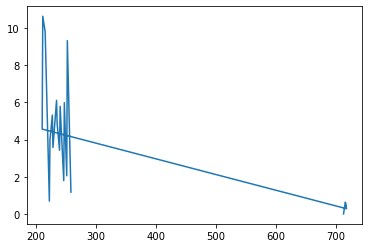

In [258]:
# plt.plot(df_one_station["cum_months"], df_one_station["data_in"])
start = 480
end = 500
plt.plot(df_another_station["cum_months"][start:end], df_another_station["data_in"][start:end])

In [259]:
df_another_station["cum_months"][start:end]

170798    713
171168    716
171543    717
171921    718
172288    210
172666    211
173046    215
173426    222
173812    223
174190    227
174573    228
174950    234
175333    235
175717    239
176095    240
176464    246
176826    247
177192    251
177556    252
177924    258
Name: cum_months, dtype: int64

In [260]:
df_another_station["year"][start:end]

170798    2007
171168    2007
171543    2007
171921    2007
172288    1965
172666    1965
173046    1965
173426    1966
173812    1966
174190    1966
174573    1966
174950    1967
175333    1967
175717    1967
176095    1967
176464    1968
176826    1968
177192    1968
177556    1968
177924    1969
Name: year, dtype: int64

In [261]:
df_another_station[start:end]

,skn,year,month,data_in,Lat_DD,Lon_DD_updated,lat,lon,air,air.1,...,pr_wtr,shum,shum.1,shum.2,shum.3,shum.4,shum.5,skt,slp,cum_months
170798,2.0,2007,5,0.010000,19.10866,204.174455,20.0,205.0,296.38644,29.610008,...,28.584837,-8.370892,-73.083950,-0.082898,3.040518,2.071999,11.261000,23.981080,1018.16650,713
171168,2.0,2007,8,0.640000,19.10866,204.174455,20.0,205.0,297.74350,28.770004,...,32.350320,-16.198235,-76.977440,-2.513524,-6.196371,3.490999,11.916000,25.385939,1016.16724,716
171543,2.0,2007,9,0.540000,19.10866,204.174455,20.0,205.0,297.99707,29.659996,...,34.170334,-12.184459,-85.939170,-1.133435,0.596836,4.048000,11.936001,25.671793,1015.80700,717
171921,2.0,2007,10,0.290000,19.10866,204.174455,20.0,205.0,297.62620,30.450005,...,29.720325,-12.523946,-91.713220,-1.236699,-4.908974,1.962999,11.973000,25.703854,1016.69810,718
172288,2.0,1965,6,4.568521,19.10866,204.174455,20.0,205.0,296.19504,29.590004,...,28.622673,-9.366145,-74.941460,-2.419766,-10.371448,2.085999,11.152000,24.422123,1017.60130,210
172666,2.0,1965,7,10.630000,19.10866,204.174455,20.0,205.0,296.97946,29.980003,...,30.832903,-6.770097,-61.725773,-0.289521,-4.721602,2.226999,11.516001,25.064207,1015.76470,211
173046,2.0,1965,11,9.790000,19.10866,204.174455,20.0,205.0,297.18738,30.769997,...,34.123005,-6.268667,-59.925213,0.000000,6.683478,3.166000,11.327999,25.573963,1014.87370,215
173426,2.0,1966,6,0.700000,19.10866,204.174455,20.0,205.0,297.02988,28.360000,...,29.726330,-13.100716,-81.188140,-1.006219,-8.011169,1.973000,11.957001,25.286526,1017.22577,222
173812,2.0,1966,7,3.970000,19.10866,204.174455,20.0,205.0,297.28850,28.580002,...,31.528710,-7.973143,-78.873276,-1.390903,-7.553028,1.959000,12.382000,25.790745,1015.85780,223
174190,2.0,1966,11,5.320000,19.10866,204.174455,20.0,205.0,297.46950,30.920006,...,33.967000,-7.106743,-57.890580,2.488982,22.946575,3.275000,11.648001,26.058844,1014.11660,227


In [273]:
df_data_clean = df_data_original.drop(labels=["Lat_DD", "Lon_DD_updated", "year", "month", "lat", "lon"], axis=1)
df_data_clean.head()

,skn,data_in,air,air.1,hgt,hgt.1,omega,pottmp,pottmp.1,pr_wtr,shum,shum.1,shum.2,shum.3,shum.4,shum.5,skt,slp,cum_months
0,1.00,3.200000,295.39603,31.299995,5799.5483,121.48387,0.023998,-26.433594,-3.926514,29.034512,2.592493,-25.859348,0.589191,7.106412,2.945999,9.869999,23.385218,1014.0849,1
1,2.00,5.950000,295.39603,31.299995,5799.5483,121.48387,0.023998,-26.433594,-3.926514,29.034512,2.592493,-25.859348,0.589191,7.106412,2.945999,9.869999,23.385218,1014.0849,1
2,2.20,11.500000,295.39603,31.299995,5799.5483,121.48387,0.023998,-26.433594,-3.926514,29.034512,2.592493,-25.859348,0.589191,7.106412,2.945999,9.869999,23.385218,1014.0849,1
3,2.25,5.515941,295.39603,31.299995,5799.5483,121.48387,0.023998,-26.433594,-3.926514,29.034512,2.592493,-25.859348,0.589191,7.106412,2.945999,9.869999,23.385218,1014.0849,1
4,2.26,4.310617,295.39603,31.299995,5799.5483,121.48387,0.023998,-26.433594,-3.926514,29.034512,2.592493,-25.859348,0.589191,7.106412,2.945999,9.869999,23.385218,1014.0849,1


In [277]:
Y = np.array(df_data_clean["data_in"])
X = np.array(df_data_clean.iloc[:,2:])

In [278]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [279]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2)

In [280]:
model = LinearRegression()

In [281]:
model.fit(Xtrain, Ytrain)
Yhat = model.predict(Xtest)

In [282]:
mse(Ytest, Yhat)

34.51249406251491

In [283]:
Yhat[:10]

array([ 5.76537668,  7.13198791,  6.92960422,  1.41790563,  4.96745403,
        3.24905283,  9.84693948,  6.31474172, 10.5492591 ,  5.95901542])

In [284]:
Ytest[:10]

array([3.06     , 2.3      , 1.84     , 2.18     , 0.54     , 0.22     ,
       9.74     , 4.412382 , 1.74     , 1.7659583])

## One station, perfect prediction?

In [237]:
df_one_station = df_one_station.drop(labels=["Lat_DD", "Lon_DD_updated", "year", "month", "lat", "lon"], axis=1)
Y = np.array(df_one_station["data_in"])
X = np.array(df_one_station.iloc[:, 1:])
X = scaler.fit_transform(X)
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2)
model.fit(Xtrain, Ytrain)
Yhat = model.predict(Xtest)
mse(Ytest, Yhat)

5.369540275121883e-29

In [241]:
# df_another_station = df_another_station.drop(labels=["Lat_DD", "Lon_DD_updated", "year", "month", "lat", "lon"], axis=1)
Y = np.array(df_another_station["data_in"])
X = np.array(df_another_station.iloc[:, 1:])
X = scaler.fit_transform(X)
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2)
model.fit(Xtrain, Ytrain)
Yhat = model.predict(Xtest)
mse(Ytest, Yhat)

1.0153642104779905e-29

## Why? Too good to be true...

In [244]:
df_one_station_sorted = df_one_station.sort_values(by=['cum_months'])

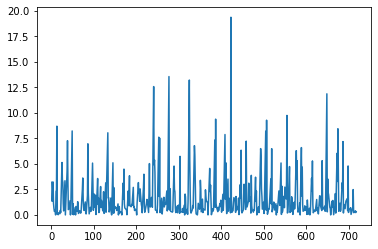

In [247]:
plt.plot(df_one_station_sorted["cum_months"], df_one_station_sorted["data_in"])

In [251]:
df_data_original.shape

(865561, 25)

In [272]:
# how about standard deviation per month?
model.coef_

array([ 1.62530000e+02, -1.12548666e-14, -6.24095952e-14,  2.58154810e-14,
        3.37109361e-15,  4.26794380e-15,  8.68701976e-14,  9.42933042e-15,
        2.50690813e-14,  6.78977495e-15,  2.11986243e-14, -4.21619337e-14,
        4.49729229e-14,  4.62901613e-14,  8.94135314e-15, -1.97109668e-14,
        1.28066550e-14, -7.51317609e-16])